In [134]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import keras.backend as K

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

## Loading Data  
The dataset of spam and ham (not spam) messages can be downloaded from this [link](https://drive.google.com/file/d/11Z8bt9TwilZ1GLJFcJwWBykOicVT0ZzH/view?usp=sharing). This data is loaded using pandas, then shuffled before separating the messages and the labels. It can be seen that the data is skewed (the number of spam messages are fewer than the number of not spam messages.

In [2]:
# seed for reproducability
np.random.seed(3)

# reading data
data = pd.read_csv("./spam.csv", encoding = "ISO-8859-1")

# only keep the required columns
data = data[["v1", "v2"]]

# shuffle data and view the first few
data = shuffle(data)
display(data[:5])
print("\n")

# separate the messages from the class labels (0 for spam and 1 for ham)
msgs = np.array(data["v2"])
labels = np.array(data["v1"] == "ham")

# determine the number of data-points, assert completeness
num_msgs = len(msgs)
assert(len(labels) == num_msgs)
print("Total number of messages: ", num_msgs)

# some data statistics
num_ham = len([a for a in labels if a])
num_spam = num_msgs - num_ham
print("Number of spam messages:", num_spam)
print("Number of non-spam messages:", num_ham)

,v1,v2
2632,ham,I WILL CAL YOU SIR. In meeting
454,spam,"Loan for any purpose å£500 - å£75,000. Homeown..."
983,ham,LOOK AT THE FUCKIN TIME. WHAT THE FUCK YOU THI...
1282,ham,Ever green quote ever told by Jerry in cartoon...
4610,ham,Wat time Ì_ finish?




Total number of messages:  5572
Number of spam messages: 747
Number of non-spam messages: 4825


## Data Pre-processing  
The messages are passed through a *tokenizer* which assigns a unique *id* to each word. Following this, the resulting word vecotrs are padded (by putting 0s is the start), so that they are all of the same length (decided by the *max_len* variable). A value of 100 for *max_len* is chosen assuming that it is possible to identify the intent of a message within the first 100 words. Finally, the data is first split into train and test set (the test set would be the set used for final metric evaluation). A train test split of 87.5-12.5 is suitable according to the number of records.

In [3]:
# converting messages into integer word vectors
tokenizer = Tokenizer()
tokenizer.fit_on_texts(msgs)
word_vectors = tokenizer.texts_to_sequences(msgs)

# counting unique words
num_unique_words = len(tokenizer.word_index)
print("Number of unique words found: ", num_unique_words)

# padding the word vectors so that the inputs to the RNN are of the same size
max_len = 100
padded_data = pad_sequences(word_vectors, maxlen = max_len)

# doing the train-test split
train_test_split = 0.875
num_train = int(train_test_split * num_msgs)
x_train = padded_data[: num_train]
y_train = labels[: num_train]
x_test = padded_data[num_train: ]
y_test = labels[num_train: ]
print("Number of messages used for training purpose: ", num_train)
print("Number of messages used for testing purpose: ", num_msgs - num_train)

Number of unique words found:  8920
Number of messages used for training purpose:  4875
Number of messages used for testing purpose:  697


## Performance Metric
Since the data is skewed (only around 13% of the messages are spam), we choose to use F1 score as the evaluation metric rather than accuracy. This metric is defined below.

In [4]:
# part of old keras source code
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives/(predicted_positives + K.epsilon())
    recall = true_positives/(possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall)/(precision + recall + K.epsilon())
    return f1_val

## Optimizing the network structure
The data is evaluated using a validation set (so as to not overfit on the test set). Early stopping (based on the validation loss) is employed to prevent the model from overfitting. The first layer of the model is an Embedding layer which helps learn more context about each of the unique words in the word_index. The number of features of these embeddings is set to a suitable power of 2 i.e. 16  
Furthermore, the hyperparameters are divided into two parts: ones that are kept constant and others that are tuned.  
  
**Constant Hyperparameters**:  
1. batch_size  
2. loss_function  
3. all early stopping parameters (patience, min_delta)  
4. validation_split
5. epochs (a high value chosen, because early stopping is utilized 
  
**Tuned Hyperparameters**:
1. learning_rate  
2. number of neurons in the LSTM layers  
3. number of LSTM layers  
4. number of Dense layers  
5. activation functions for the dense layers
6. optimizer  

Insted of going through each possible value, we will do a random grid search to try to look for a model with the best F1 score.  

In [5]:
# flag to decide whether to optimize again
optimized = True

networks = []
path_to_models = "models/"

if optimized:    
    with open(path_to_models + "models.pkl", "rb") as f:
        networks = pickle.load(f)
else:
    # constant hyperparameters
    batch_size = 128
    loss_fcn = "binary_crossentropy"
    num_epochs = 50

    # setting a callback
    callback = EarlyStopping(monitor = "val_loss", restore_best_weights = True,
                            patience = 5, min_delta = 0)

    num_networks = 100
    activations = ["relu", "tanh", "elu"]
    opts = [Adam, RMSprop]

    for j in range(num_networks):

        # tunable parameters
        learning_rate = np.power(10, np.random.uniform(-3, -1.5))
        neurons = np.power(2, np.random.randint(3, 7))
        num_lstm = np.random.randint(1, 4)
        num_dense = np.random.randint(0, 3)
        activation = np.random.choice(activations)
        opt = np.random.choice(opts)
        hyper_params = {
            "learning_rate": learning_rate,
            "num_neurons": neurons,
            "num_lstm_layers": num_lstm,
            "num_dense_layers": num_dense,
            "dense_activation_function": activation,
            "optimizer": opt
        }
        print(f"Network number {j+1} training with hyperparameters:", hyper_params)

        # building a model

        # initializing and adding an Embedding layer
        model = Sequential()
        model.add(Embedding(num_unique_words + 1, 16))

        # adding the required number of LSTM layers
        for i in range(num_lstm):
            r_seq = True
            if i == num_lstm - 1:
                r_seq = False
            model.add(LSTM(neurons, return_sequences = r_seq))

        # adding the required number of dense layers
        for i in range(num_dense):
            model.add(Dense(2 ** (num_dense - i), activation = activation))

        # adding the final sigmoid layer
        model.add(Dense(1, activation = "sigmoid"))

        # compile and fit model
        model.compile(optimizer = opt(learning_rate = learning_rate), 
                     loss = loss_fcn, metrics = [f1_score])
        history = model.fit(x_train, y_train, epochs = num_epochs, batch_size = batch_size,
                           validation_split = 0.15, callbacks = [callback])

        # determine best loss and f1_score
        val_losses = history.history["val_loss"]
        min_loss = min(val_losses)
        best_f1 = history.history["val_f1_score"][val_losses.index(min_loss)]

        # save model in a file
        model.save(f"{path_to_models}{j}.h5")

        # store useful data
        networks.append({
            "hyperparameters": hyper_params,
            "model": j,
            "val_loss": min_loss, 
            "f1_score": best_f1,
        })

    # save the final results in a file
    with open(f"{path_to_models}models.pkl", "wb") as f:
        pickle.dump(networks, f)   

## Model Selection  
We will select the best model based on the least validation F1 score. For F1 scores within a reasonable range, we choose the one with the lowest validation loss.

In [6]:
# select all models with the F1 score with 0.001 range
best_score = sorted(networks, key = lambda x: -x["f1_score"])[0]["f1_score"]
candidate_models = [a for a in networks if a["f1_score"] >= best_score - 0.001]

# choose the best model based on the lowest validation loss
best_model = sorted(candidate_models, key = lambda x: x["val_loss"])[0]

# load the model into the 'model' variable
model = load_model(f"{path_to_models}{best_model['model']}.h5",
                  custom_objects = {
                      "f1_score": f1_score
                  })
best_model

{'hyperparameters': {'learning_rate': 0.008101284854412444,
  'num_neurons': 32,
  'num_lstm_layers': 1,
  'num_dense_layers': 0,
  'dense_activation_function': 'tanh',
  'optimizer': keras.optimizer_v2.rmsprop.RMSprop},
 'model': 77,
 'val_loss': 0.02567603625357151,
 'f1_score': 0.9971261620521545}

In [143]:
def plot_confusion(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(conf, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['spam', 'non-spam'])
    ax.yaxis.set_ticklabels(['spam', 'non-spam'])

## Evaluation  
We finally evaluate our chosen model on the test set.

22/22 [==============================] - 0s 10ms/step - loss: 0.0466 - f1_score: 0.9934
Accuracy of the model on the test set:  0.9885222381635581


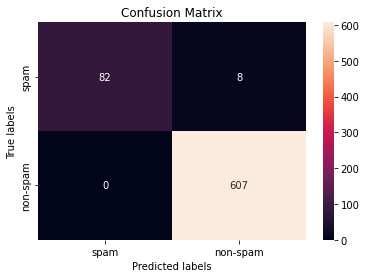

In [151]:
# evaluation metric calculation
predictions = np.round(model.predict(x_test)) == 1.
final_f1 = model.evaluate(x_test, y_test)

# confusion matrix
plot_confusion(y_test, predictions)

# accuracy
check = y_test.reshape(y_test.shape[0], 1) == predictions.reshape(predictions.shape[0], 1)
print("Accuracy of the model on the test set: ", len([a for a in check if a])/len(predictions))

## Testing on personal messages
A short collection of spams and non-spam text messages and emails are collected from our accounts/mobiles. The selected model is run on this small dataset, and the results displayed

1/1 [==============================] - 0s 27ms/step - loss: 0.3096 - f1_score: 0.9375
Accuracy of the model on the personal messages dataset:  0.9333333333333333


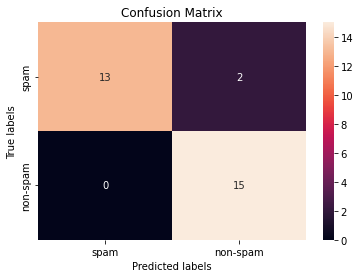

In [153]:
# the dataset of personal messages
spams = [
    "Congratulations! YOu have won a $1000 gift card. Go to https://www.bitly.com/123456 for more info.",
    "THIS CHRISTMAS YOU DO NOT RUN OUT OF DATA: Mobile 10GB + unlimited calls for only 9.90E / month. FINAL PRICE FOREVER. + info: 900696335. No + Publi bit.ly/2azyb ",
    "UNIQUE OFFER: For only 9.90E / month take 10GB on your mobile with unlimited calls. PRICE FOREVER, WITHOUT PERMANENCE. + Info 900696335. No + Publi bit.ly/2azyb ",
    "LAST DAYS! For being WOW, -35% in WOMEN'SECRET, cumulative until 12/31/21, with SMS in stores and womensecret.com. COD 544 + Inf / Stop SMS https://bit.ly/3HZUHeh ",
    "INCREDIBLE. A XIAOMI REDMI 9A 32 GB FREE, going to the Fiber 300Mb + UNLIMITED GB in the mobile. Get one. Call FREE to 900 696 985. No + Publi bit.ly/2JgaU",
    "SALES in Esdemarca! Up to 60% discount. in your favorite brands Enter! www.esdemarca.com/sms/c/22040f/7c47126c ",
    "On your birthday, get 25% on Continente Card on the birthday cake and sparkling wine (max 6 bottles) at Continente or Cartão.continente.pt/bolos. On your first purchase >€30 on Continente until 03/10, receive 1 15ct/l coupon on Continente Card to refuel at Galp. X3989X. cartao.continente.pt/galp ",
    "Irresistible sales from Jazztel! Fiber and Mobile 25GB for only 20e / month 3 months and a Samsung Galaxy A70 at 40% discount. Call now FREE at 900834316. No + publi900809400 ",
    "VF Publi: Celebrate that HBO Max is on Vodafone TV! As a customer, come to your nearest Vodafone Store and find out instantly if you win one of the exclusive HBO Max gifts. Also, will you enter the draw for a TV LG 55 ?. Find your store: go.vodafone.es/tiendavf ",
    "Vodafone: Win 1 of the 5 ALL-inclusive trips with MiércoYES! Culture + Gastro + Musical Billy Elliot for 2 people. Participate today m.vodafone.es/miercoyess ",
    "VF Publi: Just for you! Samsung Galaxy A52s 5G 128GB for only € 7.33 / month with any rate and in 36 installments. Are you going to miss it? (500 units available). Call 1444 or click here: m.vodafone.es/canjeterminal ",
    "New Samsung Galaxy Z Fold3 and Flip3 now available at Worten! Pay in 24 installments without interest and enjoy up to €800 in trade-ins, until 9/30 +Info/legal: www.wrt.pub/3ky9Pof ",
    "Airbnb - Don't miss out on these deals in Krakow. Get an incredible deal on these accommodations. Book now to enjoy the additional discounts offered by your host",
    "TheFork - Do you want to win 1 € 100 TheFork Gift Card? Raffle of 3 gift cards. Participates! ",
    "Nestle - LAST chance to WIN our Christmas Basket. Participate now and get 1 of the 10 Christmas baskets that we raffle. You are still in time to participate! "
]

not_spams = [
    "Alert RCB: Warning! Strong winds during the day, overnight and tomorrow morning (21/22.10). Possible traffic disruptions and power outages.",
    "Your invoice for the current month has been generated. Payable amount is PKR 2,547.We would appreciate if you kindly process the payment within due date i.e. 12-Jan-2022 to avoid late payment surcharge.",
    "Wishing you and yours every happiness this holiday season and throughout the coming year.",
    "Congratulations on successfully completing your degree from School of Mechanical and Manufacturing Engineering, SMME NUST. It is indeed a proud and momentous achievement for all of you graduates and the one that should be recognised through a formal ceremony of Convocation.",
    "@hamishaider has invited you to collaborate on the hamishaider/mi_detection repository You can accept or decline this invitation. You can also visit @hamishaider to learn a bit more about them.This invitation will expire in 7 days.",
    "I know that on Thursday there is a JEMARO meeting. As I got information from prof. Zielińska, you can be excused of Polish class if you want to take part at that meeting. So it's your decision where you would like to be, just inform me about it.",
    "This is to inform you that we have received a payment of PKR 2,547.00 on 02-Dec-2021 at 06:26:44 (Excluding Bank Charges).Remaining balance is PKR 0.00. (-) Negative amount reflects outstanding payment.(+) Positive amount reflects excess payment in your account. Thanks for your payment. We look forward to keep serving you.",
    "Your visa application has been sent to the Decision Making Centre for processing. You can track the progress of your visa application by connecting to your account.",
    "I contacted my supervisor and I have the permission to make tomorrow's class on-line for all.",
    "The other teachers have also shifted to Teams for the week. We are fine with Teams.",
    "Please be aware of all required travel documentation. Failure to present mandatory documentation may result in your boarding/entry to your destination being denied and, in some cases, may result in expensive fines",
    "Click on the button below to proceed to filling out the KLP form. Use the form to report your arrival to Poland.",
    "Thanks for providing the info we requested. If you uploaded more than one document, keep an eye on your inbox. We’ll let you know when they’ve also been confirmed.",
    "Internees will work on 3D designing,3D modeling, industrial design project, Solid-works, auto desk inventor, industrial design, machine design, CAD Drawing,3D Printing, Laser cutting, CNC milling, lathe, wire EDM & much more.",
    "Pity you didn't call me. I put the link to Teams to all groups and I already finished. I had a class before so I couldn't read your message before. I can just send you the presentation."
]

# preparing the messages for the network
p_msgs = spams + not_spams
p_labels = [False] * len(spams) + [True] * len(not_spams)
p_labels = np.array(p_labels)
p_seq = tokenizer.texts_to_sequences(p_msgs)
p_seq = pad_sequences(p_seq, maxlen = max_len)

# predictions
p_pred = model.predict(p_seq)
p_pred = np.round(p_pred) == 1.
model.evaluate(p_seq, p_labels)

# plot confusion matrix
plot_confusion(p_labels, p_pred)

# accuracy
check = p_labels.reshape(p_labels.shape[0], 1) == p_pred.reshape(p_pred.shape[0], 1)
print("Accuracy of the model on the personal messages dataset: ", len([a for a in check if a])/len(p_pred))